# Image classification - Sci-kit Learn
___

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.insert(0, './python')

from os import listdir

from Utils import *
from Transformer import RGB2GrayTransformer, HogTransformer

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.base import clone

In [2]:
width, height = 90, 90

image_path = "assets/image/"
output_path = "assets/data/"
directories = [_ for _ in listdir(image_path)]#[5::2]

df_save_loc = output_path+"DataFrame_{0}x{1}px.pkl".format(width, height)
grid_save_loc = output_path+"GridSearch_model.pkl"
encoder_save_loc = output_path+"LabelEncoder.pkl"

## Déclaration et affichages des données du DataFrame
___

In [3]:
df = get_data(image_path, directories, width, height)
df = df.sample(frac=1) # shuffle
save(df, df_save_loc)
# df = load(df_save_loc)

In [4]:
df.head()

,label,filename,rgb,description
1099,PandaHead,giant_panda_41506_233785.jpg,"[[[100, 103, 76], [107, 102, 80], [80, 68, 53]...",Image d'un PandaHead redimensionnée (90x90) en...
266,DogHead,dog000006b.jpg,"[[[100, 105, 49], [100, 105, 49], [100, 105, 4...",Image d'un DogHead redimensionnée (90x90) en RGB
461,DogHead,dog000402a.jpg,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Image d'un DogHead redimensionnée (90x90) en RGB
371,DogHead,dog000187a.jpg,"[[[36, 83, 215], [36, 83, 215], [37, 83, 215],...",Image d'un DogHead redimensionnée (90x90) en RGB
816,ElephantHead,0000000067.jpg,"[[[178, 182, 206], [178, 182, 206], [178, 182,...",Image d'un ElephantHead redimensionnée (90x90)...


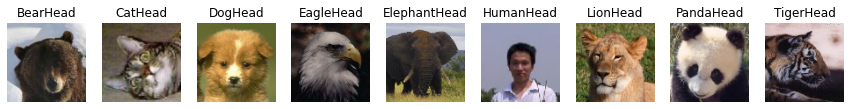

In [5]:
fig = debug_df(df,)

<AxesSubplot:title={'center':"Distribution des classes sur l'ensemble du dataset"}, xlabel='label', ylabel='Count'>

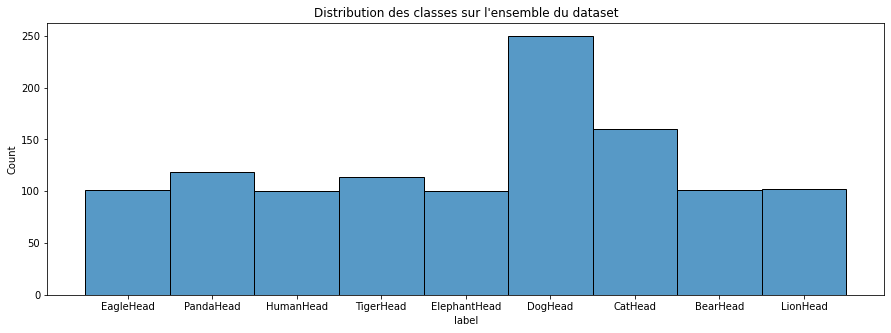

In [5]:
fig, ax = plt.subplots(figsize=[15, 5])
ax.set_title("Distribution des classes sur l'ensemble du dataset")
sns.histplot(df["label"], ax=ax)

## Pre processing
### - Encodage des labels
### - Redimension, grayscale, (rescale), HOG sur les features
___

In [6]:
encoder = load(encoder_save_loc)
# encoder = LabelEncoder()
# encoder.fit(np.array(df["label"]))
# save(encoder, encoder_save_loc)

In [7]:
X = np.array(list(df["rgb"]))
y = encoder.transform(np.array(df["label"]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y)

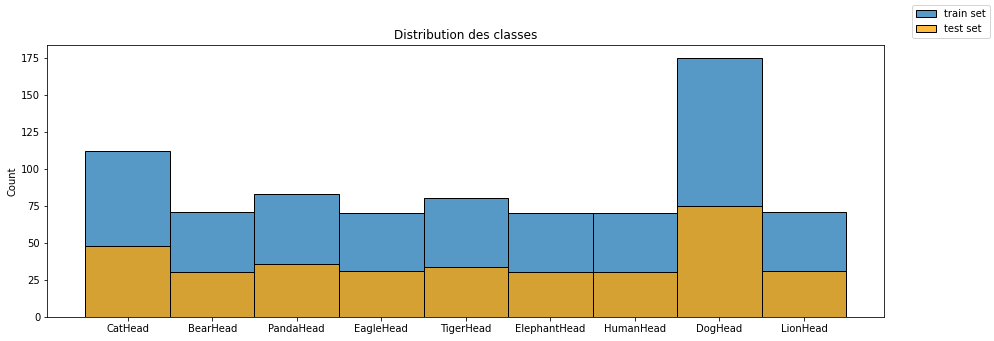

In [9]:
fig, ax = plt.subplots(figsize=[15, 5])
ax.set_title("Distribution des classes")
sns.histplot(encoder.inverse_transform(y_train), ax=ax, label="train set")
sns.histplot(encoder.inverse_transform(y_test), ax=ax, label="test set", color="orange")
fig.legend()

### Étape par étape

C:\Users\m4tt\Machine Learning\Image Classifier\Transformer.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([hog(x, pixels_per_cell=self.ppc, cells_per_block=self.cpb, orientations=self.orientations,


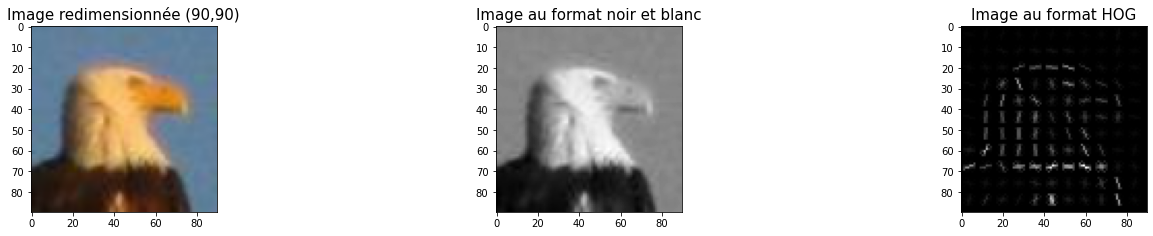

In [9]:
X_debug = X[0][np.newaxis, ...]
debug_pipeline_steps(X_debug)

In [7]:
preprocess = Pipeline([
    ("gt", RGB2GrayTransformer()),
    ("ht", HogTransformer()),
    ("std", StandardScaler()),
])

clf_generic = Pipeline([
    ("pp", preprocess),
    ("estimator", SGDClassifier(verbose=2, n_jobs=-1)),
])

## Entrainement du modèle et évaluation de l'accuracy, CV score, matrice de confusion
___

In [8]:
%%capture
clf = clone(clf_generic)
cv_score = cross_val_score(clf, X_train, y_train, scoring="accuracy", cv=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)

In [9]:
f"Accuracy Score (test set):{acc_score}, CV Score:{np.mean(cv_score)}"

'Accuracy Score (test set):0.8115942028985508, CV Score:0.7443820224719101'

<AxesSubplot:>

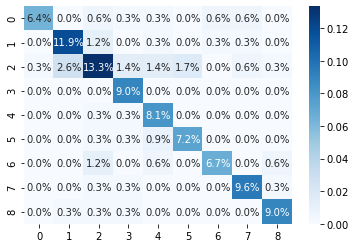

In [10]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.1%', cmap='Blues')

## GridSearchCV - SVC & SGDClassifier
___

In [39]:
params_grid = [{ 
                'estimator':[SVC()],
                "estimator__kernel": ["linear"],
                "estimator__max_iter": [-1],
                'estimator__C': [0.005, 0.0025, .001, .01, .1, 1],
                "estimator__shrinking": [True, False],
                'pp__ht__cpb': [(3, 3), (4, 4)],
                'pp__ht__ppc': [(8, 8),],
                'pp__ht__orientations': [8, 9],
                },
#                 {
#                 'estimator': [SGDClassifier()],
#                 'estimator__alpha': [0.0001, 0.001],
#                 'pp__ht__cpb': [(2, 2), (3, 3)],
#                 'pp__ht__ppc': [(8, 8),],
#                 'pp__ht__orientations': [8],
#                 },
                ]

In [45]:
# grid = GridSearchCV(clf, params_grid, cv=3, verbose=1, n_jobs=-1,  return_train_score=True, scoring="accuracy")
# grid.fit(X_train, y_train)
# save(grid, grid_save_loc)

In [8]:
grid = load(grid_save_loc)

### Résultats du GridSearch

In [10]:
res = grid.cv_results_
sort_by_rank = res["rank_test_score"].argsort()
scores = res["mean_test_score"][sort_by_rank]
estimators = np.array(res["params"])[sort_by_rank]
estimators[:3]

array([{'estimator': SVC(C=0.005, kernel='linear'), 'estimator__C': 0.001, 'estimator__kernel': 'linear', 'estimator__max_iter': -1, 'estimator__shrinking': True, 'pp__ht__cpb': (4, 4), 'pp__ht__orientations': 8, 'pp__ht__ppc': (8, 8)},
       {'estimator': SVC(C=0.005, kernel='linear'), 'estimator__C': 0.0025, 'estimator__kernel': 'linear', 'estimator__max_iter': -1, 'estimator__shrinking': False, 'pp__ht__cpb': (4, 4), 'pp__ht__orientations': 8, 'pp__ht__ppc': (8, 8)},
       {'estimator': SVC(C=0.005, kernel='linear'), 'estimator__C': 0.001, 'estimator__kernel': 'linear', 'estimator__max_iter': -1, 'estimator__shrinking': False, 'pp__ht__cpb': (4, 4), 'pp__ht__orientations': 8, 'pp__ht__ppc': (8, 8)}],
      dtype=object)

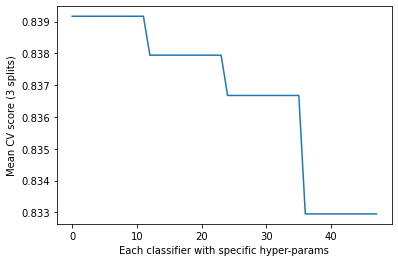

In [11]:
fig, ax = plt.subplots()
ax.set_xlabel("Each classifier with specific hyper-params")
ax.set_ylabel("Mean CV score (3 splits)")
ax.plot(range(estimators.size), scores)

In [12]:
f"CV score du meilleur modèle (accuracy): {scores[0]}"

'CV score du meilleur modèle (accuracy): 0.8391702536009094'

In [44]:
y_pred = grid.predict(X_test)
f"Accuracy du meilleur modèle sur le test set: {accuracy_score(y_test, y_pred)}"

'Accuracy du meilleur modèle sur le test set: 0.8521739130434782'

## Prédictions

In [14]:
def predict(img_data):
    return encoder.inverse_transform(grid.predict(img_data.reshape(-1, width, height, 3)))

In [17]:
predict(X_test[:10])

array(['LionHead', 'DogHead', 'PandaHead', 'LionHead', 'DogHead',
       'ElephantHead', 'PandaHead', 'LionHead', 'DogHead', 'PandaHead'],
      dtype=object)

In [18]:
encoder.inverse_transform(y_test[:10])

array(['LionHead', 'DogHead', 'PandaHead', 'LionHead', 'TigerHead',
       'ElephantHead', 'PandaHead', 'CatHead', 'DogHead', 'PandaHead'],
      dtype=object)